In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
# % matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,GradientBoostingClassifier
from sklearn import metrics

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2  
import h5py
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50

In [3]:
my_arrays_final = np.load("/kaggle/input/updated-112/Car_damage_aug_dataset_final_1.npz", allow_pickle=True)


In [4]:
# Extract the X_train, y_train, X_test, and y_test arrays from the data
X_train = my_arrays_final['X_train']
y_train = my_arrays_final['y_train']
X_test = my_arrays_final['X_test']
y_test = my_arrays_final['y_test']

In [5]:
# Print the shapes of the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (14738, 128, 128, 3)
y_train shape: (14738,)
X_test shape: (6317, 128, 128, 3)
y_test shape: (6317,)


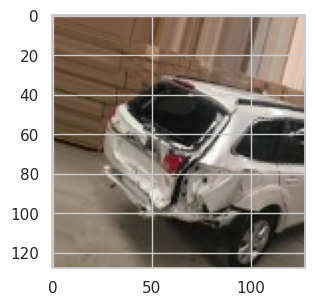

In [6]:
plt.subplot(121)
img = np.reshape(X_train[5000], (128,128,3))
plt.imshow(img)

In [7]:
keep_prob = 0.5
# Load the ImageNet VGG model. Notice we exclude the densely #connected layer at the top
vggModel= tf.keras.applications.VGG16( weights='imagenet', include_top=False, input_shape=(128, 128, 3))

vggModel.trainable= False

model = tf.keras.models.Sequential()
#We now add the vggModel directly to our new model
model.add(vggModel)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 1 - keep_prob))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

print (model.summary())


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_____________________________________

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),metrics=['accuracy'])

H = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
461/461 [==============================] - 24s 37ms/step - loss: 3.3089 - accuracy: 0.4314 - val_loss: 0.9944 - val_accuracy: 0.4643
Epoch 2/100
461/461 [==============================] - 15s 33ms/step - loss: 1.0352 - accuracy: 0.4706 - val_loss: 0.8940 - val_accuracy: 0.5762
Epoch 3/100
461/461 [==============================] - 15s 33ms/step - loss: 0.9807 - accuracy: 0.4933 - val_loss: 0.9092 - val_accuracy: 0.5376
Epoch 4/100
461/461 [==============================] - 15s 34ms/step - loss: 0.9380 - accuracy: 0.5263 - val_loss: 0.8752 - val_accuracy: 0.5864
Epoch 5/100
461/461 [==============================] - 15s 33ms/step - loss: 0.8885 - accuracy: 0.5563 - val_loss: 0.8318 - val_accuracy: 0.6183
Epoch 6/100
461/461 [==============================] - 15s 33ms/step - loss: 0.8550 - accuracy: 0.5884 - val_loss: 0.8230 - val_accuracy: 0.5925
Epoch 7/100
461/461 [==============================] - 14s 31ms/step - loss: 0.8174 - accuracy: 0.6073 - val_loss: 0.8072 - val_ac

In [9]:
featuresTrain_1= model.predict(X_train)

#reshape to flatten feature for Train data
featuresTrain_1= featuresTrain_1.reshape(featuresTrain_1.shape[0], -1)

featuresVal_1= model.predict(X_test)
#reshape to flatten feature for Test data
featuresVal_1= featuresVal_1.reshape(featuresVal_1.shape[0], -1)


198/198 [==============================] - 4s 20ms/step


In [10]:
np.save('/kaggle/working/FineTuneVGGfeatures_128*128_train_1', featuresTrain_1)
np.save('/kaggle/working/FineTuneVGGfeatures_128*128_val_1', featuresVal_1)

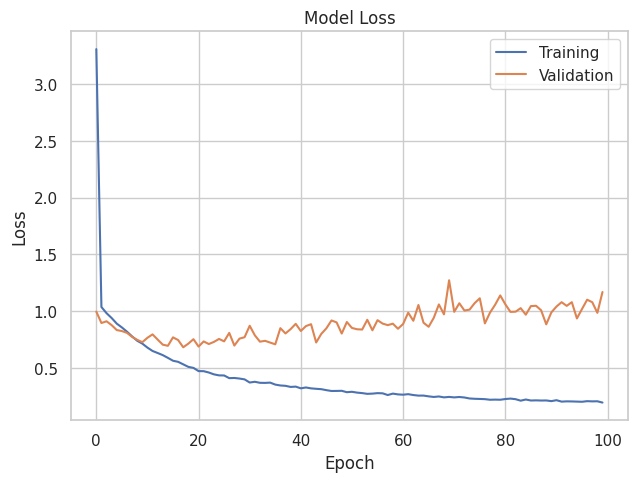

In [11]:
# Plot the training and validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])

# Set the title and axis labels
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add a legend for the plot
plt.legend(['Training', 'Validation'], loc='upper right')

# Show the plot
plt.show()

In [12]:
model.save('/kaggle/working/car_damage_1.h5')

In [13]:
from sklearn.metrics import classification_report

# Assuming 'model' is the trained model and 'X_test' and 'y_test' are the test data
y_pred = np.argmax(model.predict(X_test), axis=-1) # convert predicted probabilities to class labels

# Generate the classification report
print(classification_report(y_test, y_pred))


198/198 [==============================] - 4s 20ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2023
           1       0.77      0.69      0.73      2070
           2       0.81      0.87      0.84      2224

    accuracy                           0.80      6317
   macro avg       0.80      0.80      0.80      6317
weighted avg       0.80      0.80      0.80      6317



In [18]:
# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/car_damage_1.h5')

# Load the image and preprocess it
img = Image.open('/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0060.JPEG')
img = img.resize((128, 128)) # resize the image to match the input size of the model
img_array = np.array(img) / 255.0 # normalize the pixel values to the range [0, 1]
img_array = np.expand_dims(img_array, axis=0) # add an extra dimension to represent the batch size

# Make predictions on the image using the loaded model
predictions = model.predict(img_array)

# Print the predicted class probabilities
print(predictions)

1/1 [==============================] - 0s 224ms/step
[[0.3328135 0.5339008 0.1332857]]


In [16]:
# Assuming 'predictions' is the array of predicted class probabilities
pred_class = np.argmax(predictions, axis=1)

# Print the predicted class
print(pred_class)


[1]


In [ ]:
vggModel.trainable = True
trainableFlag = False

for layer in vggModel.layers:
    if layer.name == 'block4_conv1':
        trainableFlag = True
    if layer.name == 'block4_conv2':
        trainableFlag = True
    if layer.name == 'block4_conv3':
        trainableFlag = True
    if layer.name == 'block4_pool':
        trainableFlag = True
#    if layer.name == 'block5_conv1':
#        trainableFlag = True
#     if layer.name == 'block5_conv2':
#         trainableFlag = True
#     if layer.name == 'block5_conv3':
#         trainableFlag = True
#     if layer.name == 'block5_pool':
#         trainableFlag = True
    layer.trainable = trainableFlag
    
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                               # epsilon=None, decay=0.0, amsgrad=Fals,metrics=['accuracy'])
print (model.summary())
H2 = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
